# Baby CT/SA/Covariance gradients

webercl@cbs.mpg.de

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from brainspace.datasets import fetch_timeseries_preprocessing
from scipy.stats import spearmanr
from brainspace.datasets import load_conte69
from brainspace.plotting import plot_hemispheres
from brainspace.utils.parcellation import map_to_labels
from cmcrameri import cm
from brainstat.stats.terms import MixedEffect, FixedEffect
from brainstat.stats.SLM import SLM 
from nilearn import plotting
from pingouin import partial_corr

In [2]:
# get data
babydata = pd.read_csv('/Users/claraweber/Desktop/MPI/babybrains/Full_dataset.csv')
labels = np.asarray(pd.read_csv('/Users/claraweber/Desktop/MPI/babybrains/Full_dataset_labelkeys.csv', sep=';'))[0]

# change delimiter in above command!!

# split up data into CT And SA
ct_filter = [col for col in babydata.columns if "thickness" in col]
data_CT = np.asarray(babydata[ct_filter])
sa_filter = [col for col in babydata.columns if "SA" in col]
data_SA = np.asarray(babydata[sa_filter])

# split up labels into CT And SA
labels_CT = labels[7:303]
labels_SA = labels[303:]

# sanity check
print(len(labels_SA)==len(labels_CT), data_CT.shape == data_SA.shape, data_CT.shape, len(labels_CT))

True True (552, 296) 296


In [3]:
# sort to labels
def sort_to_labels(data_in, labels_in):
    data_in_t = data_in.T
    sorted = np.zeros((552,300))
    for i in range(300):
        try:
            sorted[:,i] = data_in_t[labels_in == i]
        except:
            pass
    return sorted

In [4]:
CT_sorted = sort_to_labels(data_CT, labels_CT)
SA_sorted = sort_to_labels(data_SA, labels_SA)

## Plot SA and CT raw

In [5]:
# load prerequisites
surf_lh, surf_rh = load_conte69()

# surfaces
babysurfL = nib.load('/Users/claraweber/Desktop/MPI/babybrains/week-40_hemi-left_space-dhcpSym_dens-32k_midthickness.surf.gii')
babysurfR = nib.load('/Users/claraweber/Desktop/MPI/babybrains/week-40_hemi-right_space-dhcpSym_dens-32k_midthickness.surf.gii')

# parcels
babylabelsL = nib.load('/Users/claraweber/Desktop/MPI/babybrains/v_parcels_L.label.gii')
babylabelsR = nib.load('/Users/claraweber/Desktop/MPI/babybrains/v_parcels_R.label.gii')
babyparc = np.hstack([babylabelsR.darrays[0].data, babylabelsL.darrays[0].data])

mask = babyparc == 0

In [6]:
# define mapping to labels
def parc2surf(data_in):
    data_out = np.zeros((64984,552))
    for i in range(300):
        data_out[babyparc ==i] = data_in[:,i]
    return data_out

/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


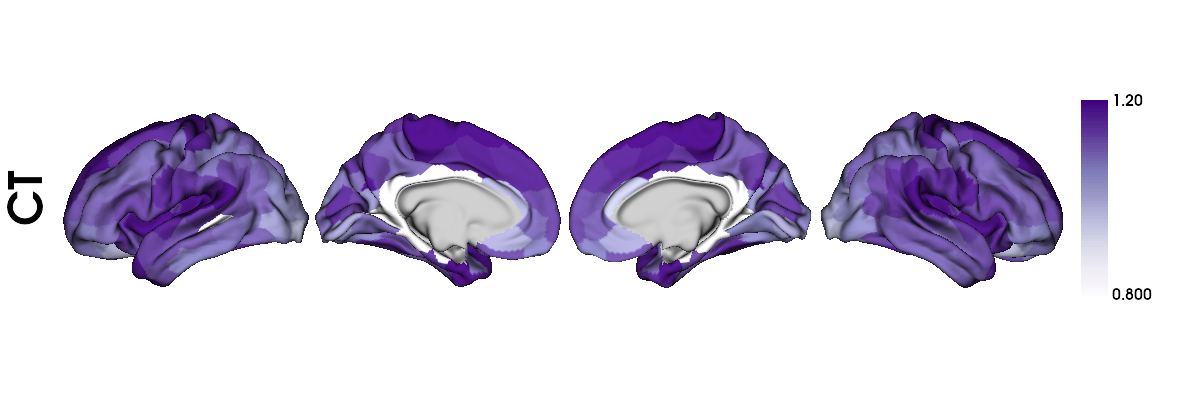

In [7]:
# map to labels
CT_plot = parc2surf(CT_sorted)

# 2D to 1D
CT_plot = np.mean(CT_plot, axis=1, dtype = 'f')

# mask median surface
mask = babyparc == 0
CT_plot[mask] = np.nan

plot_hemispheres(surf_lh, surf_rh, CT_plot, size=(1200, 400), label_text= ['CT'], cmap='Purples', color_range = (0.8, 1.2), 
nan_color = (0.7,0.7,0.7,1),color_bar=True, zoom=1.25, embed_nb = True)

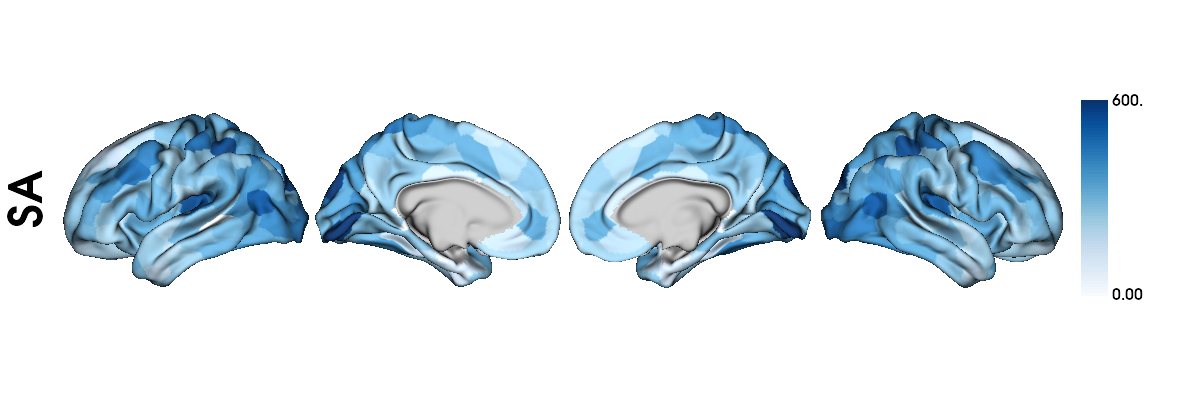

In [8]:
# map to labels
SA_plot = parc2surf(SA_sorted)

# 2D to 1D
SA_plot = np.mean(SA_plot, axis=1, dtype = 'f')

# mask median surface
mask = babyparc == 0
SA_plot[mask] = np.nan

plot_hemispheres(surf_lh, surf_rh, SA_plot, size=(1200, 400), label_text= ['SA'], cmap='Blues', color_range = (0, 600), 
nan_color = (0.7,0.7,0.7,1),color_bar=True, zoom=1.25, embed_nb = True)

## Covariance

Text(0.5, 1.0, 'ICV Distribution')

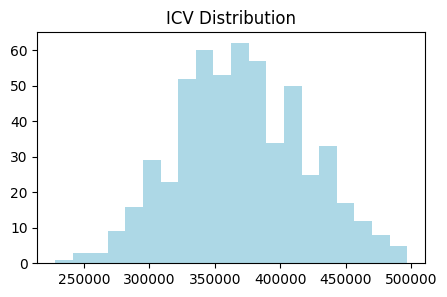

In [9]:
icv = np.asarray(babydata['Total brain volume (mm3)'], dtype = 'f')

# plot ICV
plt.figure(figsize=(5, 3))
plt.hist(icv, bins=20, color='lightblue')
plt.title('ICV Distribution')

In [10]:
thick2area = np.zeros(300)
for i in range(300):
    try:
        df = pd.DataFrame({'CT': CT_sorted[:,i], 'SA': SA_sorted[:,i], 'icv': icv})
        pc = partial_corr(data = df, x='CT', y ='SA', covar = 'icv', method = 'spearman')
        thick2area[i] = pc.at['spearman','r']
    except:
        pass

/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))


/Users/claraweber/miniconda3/envs/neuroimage/lib/python3.12/site-packages/brainspace/plotting/surface_plotting.py:437: RuntimeWarning: Running plot_hemispheres without a display may result in a crash. For a workaround please consult https://github.com/MICA-MNI/BrainSpace/issues/66. To suppress this warning set suppress_warnings=True.
  warnings.warn(


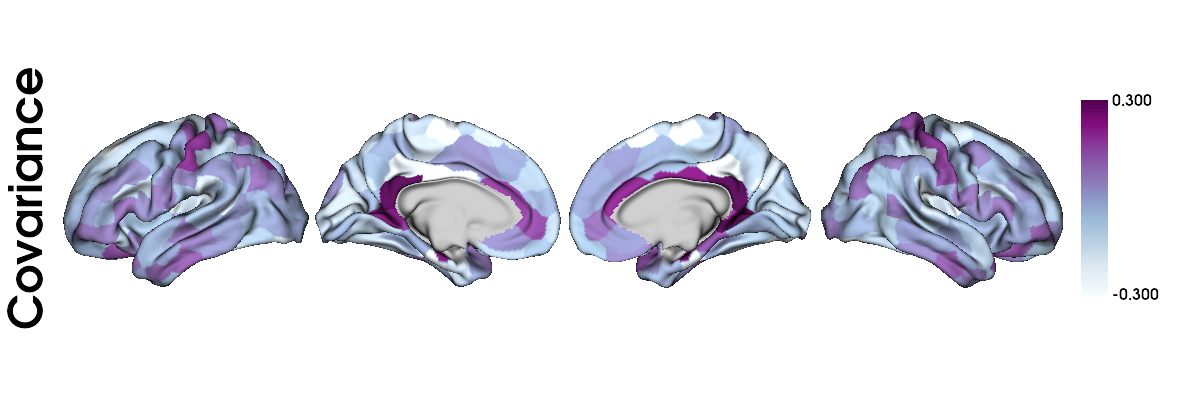

In [11]:
# map to labels
CV_plot = np.zeros((64984,))
for i in range(300):
    CV_plot[babyparc ==i] = thick2area[i]

# mask median surface
mask = babyparc == 0
CV_plot[mask] = np.nan

plot_hemispheres(surf_lh, surf_rh, CV_plot, size=(1200, 400), label_text= ['Covariance'], cmap='BuPu', color_range = (-0.3, 0.3), 
nan_color = (0.7,0.7,0.7,1),color_bar=True, zoom=1.25, embed_nb = True)

## Statistical Analysis

In [73]:
# replace ints in Sex for strings
babydata['Sex (M=1,F=2)'] = babydata['Sex (M=1,F=2)'].replace({1: 'M', 2: 'F'})

# define effects
term_age = FixedEffect(babydata['PMA at scan (weeks)'])
term_ga_at_birth = FixedEffect(babydata['GA at birth (weeks)'])
term_sex = FixedEffect(babydata['Sex (M=1,F=2)'])
term_icv = FixedEffect(babydata['Total brain volume (mm3)'])

contrast_age = babydata['PMA at scan (weeks)']
contrast_sex = (babydata['Sex (M=1,F=2)']=='M').astype(int) - (babydata['Sex (M=1,F=2)']=='F').astype(int)
contrast_gab = babydata['GA at birth (weeks)']

# define model 
model = term_age + term_ga_at_birth + term_sex + term_icv

# load surface
surf = load_conte69(join=True)

### Age

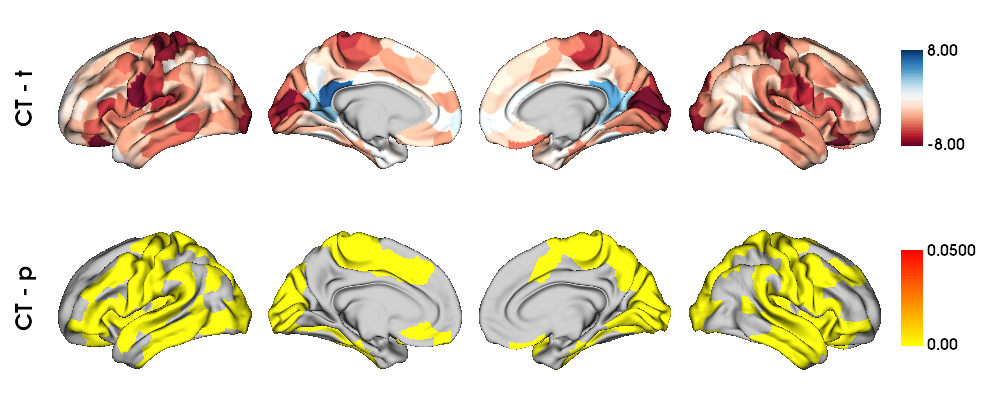

In [77]:
slm_age_ct = SLM(model, contrast_age, surf = surf, correction = ['fdr', 'rft'], cluster_threshold = 0.01)
CT_model = parc2surf(CT_sorted).T
CT_model[CT_model == np.nan] = 0
slm_age_ct.fit(CT_model)

# derive t and p values
t_age_ct = slm_age_ct.t[0]*-1 # flip sign for colormap only!
t_age_ct[mask] = np.nan

p_age_ct = slm_age_ct.P["pval"]["C"]
p_age_ct[p_age_ct>0.05] = np.nan

array_to_plot = [t_age_ct, p_age_ct]

plot_hemispheres(surf_lh, surf_rh, array_to_plot, size=(1000, 400), label_text=['CT - t', 'CT - p'], cmap=['RdBu', 'autumn_r'], color_range = [(-8,8), (0,0.05)], nan_color = (0.7,0.7,0.7,1),
                 color_bar=True, zoom=1.25, embed_nb = True)

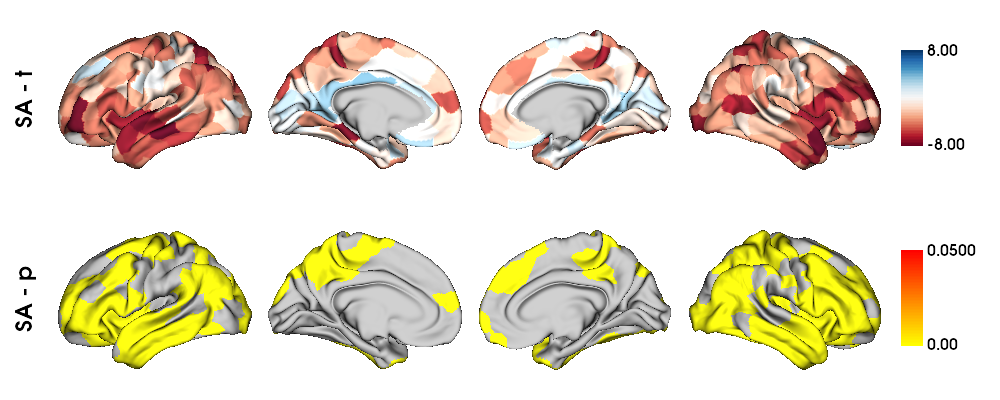

In [78]:
slm_age_sa = SLM(model, contrast_age, surf = surf, correction = ['fdr', 'rft'], cluster_threshold = 0.01)
SA_model = parc2surf(SA_sorted).T
SA_model[SA_model == np.nan] = 0
slm_age_sa.fit(SA_model)

# derive t and p values
t_age_sa = slm_age_sa.t[0]*-1
t_age_sa[mask] = np.nan

p_age_sa = slm_age_sa.P["pval"]["C"]
p_age_sa[p_age_sa>0.05] = np.nan

array_to_plot = [t_age_sa, p_age_sa]

plot_hemispheres(surf_lh, surf_rh, array_to_plot, size=(1000, 400), label_text=['SA - t', 'SA - p'], cmap=['RdBu', 'autumn_r'], color_range = [(-8,8), (0,0.05)], nan_color = (0.7,0.7,0.7,1),
                 color_bar=True, zoom=1.25, embed_nb = True)

### Sex

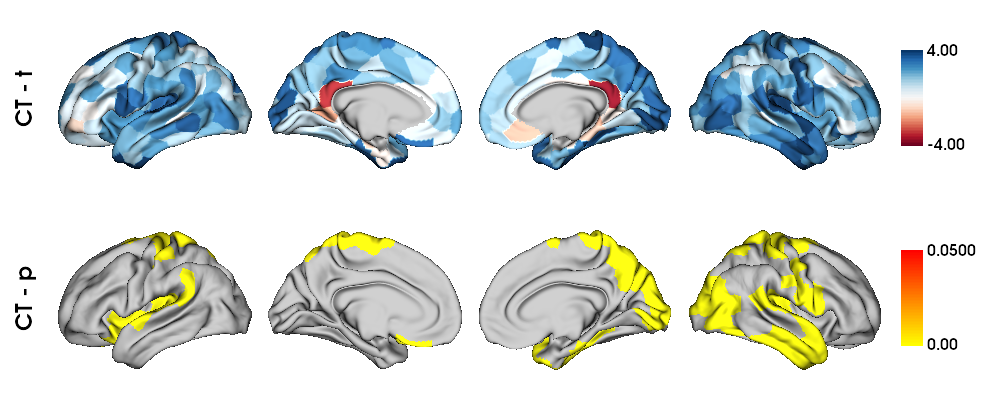

In [79]:
slm_sex_ct = SLM(model, contrast_sex, surf = surf, correction = ['fdr', 'rft'], cluster_threshold = 0.01)
slm_sex_ct.fit(CT_model)

# derive t and p values
t_sex_ct = slm_sex_ct.t[0]*-1
t_sex_ct[mask] = np.nan

p_sex_ct = slm_sex_ct.P["pval"]["C"]
p_sex_ct[p_sex_ct>0.05] = np.nan

array_to_plot = [t_sex_ct, p_sex_ct]

plot_hemispheres(surf_lh, surf_rh, array_to_plot, size=(1000, 400), label_text=['CT - t', 'CT - p'], cmap=['RdBu', 'autumn_r'], color_range = [(-4,4), (0,0.05)], nan_color = (0.7,0.7,0.7,1),
                 color_bar=True, zoom=1.25, embed_nb = True)

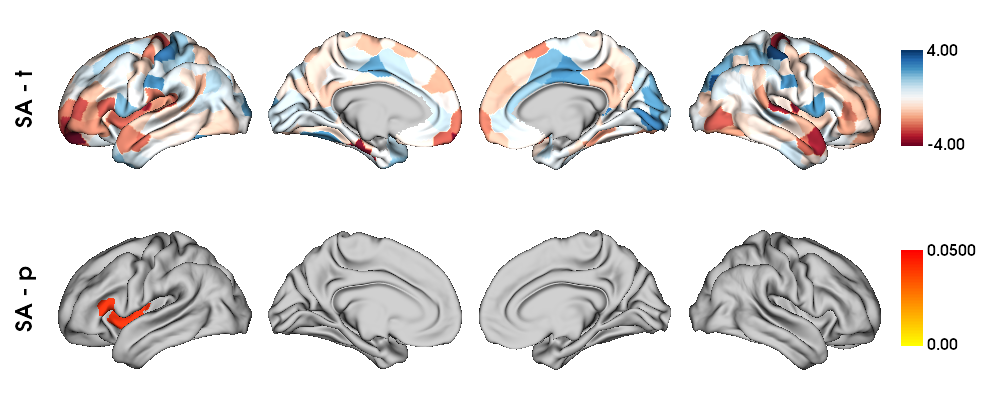

In [80]:
slm_sex_sa = SLM(model, contrast_sex, surf = surf, correction = ['fdr', 'rft'], cluster_threshold = 0.01)
slm_sex_sa.fit(SA_model)

# derive t and p values
t_sex_sa = slm_sex_sa.t[0]*-1
t_sex_sa[mask] = np.nan

p_sex_sa = slm_sex_sa.P["pval"]["C"]
p_sex_sa[p_sex_sa>0.05] = np.nan

array_to_plot = [t_sex_sa, p_sex_sa]

plot_hemispheres(surf_lh, surf_rh, array_to_plot, size=(1000, 400), label_text=['SA - t', 'SA - p'], cmap=['RdBu', 'autumn_r'], color_range = [(-4,4), (0,0.05)], nan_color = (0.7,0.7,0.7,1),
                 color_bar=True, zoom=1.25, embed_nb = True)

### GA at Birth

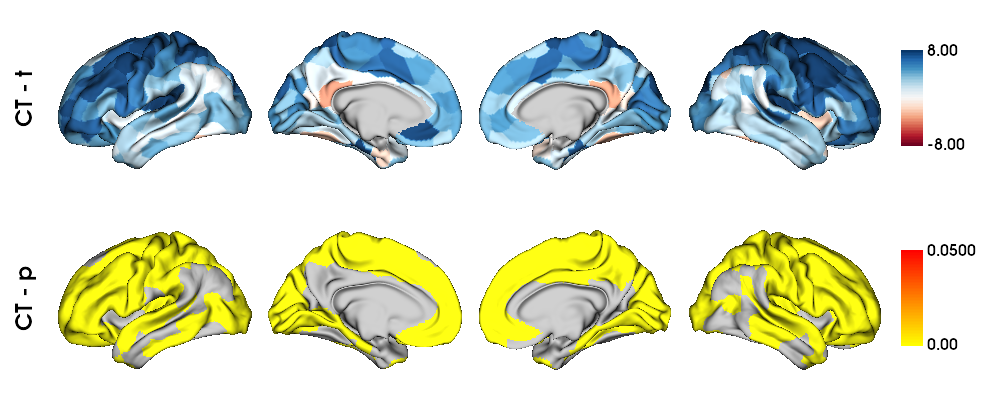

In [81]:
slm_gab_ct = SLM(model, contrast_gab, surf = surf, correction = ['fdr', 'rft'], cluster_threshold = 0.01)
slm_gab_ct.fit(CT_model)

# derive t and p values
t_gab_ct = slm_gab_ct.t[0]*-1
t_gab_ct[mask] = np.nan

p_gab_ct = slm_gab_ct.P["pval"]["C"]
p_gab_ct[p_gab_ct>0.05] = np.nan

array_to_plot = [t_gab_ct, p_gab_ct]

plot_hemispheres(surf_lh, surf_rh, array_to_plot, size=(1000, 400), label_text=['CT - t', 'CT - p'], cmap=['RdBu', 'autumn_r'], color_range = [(-8,8), (0,0.05)], nan_color = (0.7,0.7,0.7,1),
                 color_bar=True, zoom=1.25, embed_nb = True)

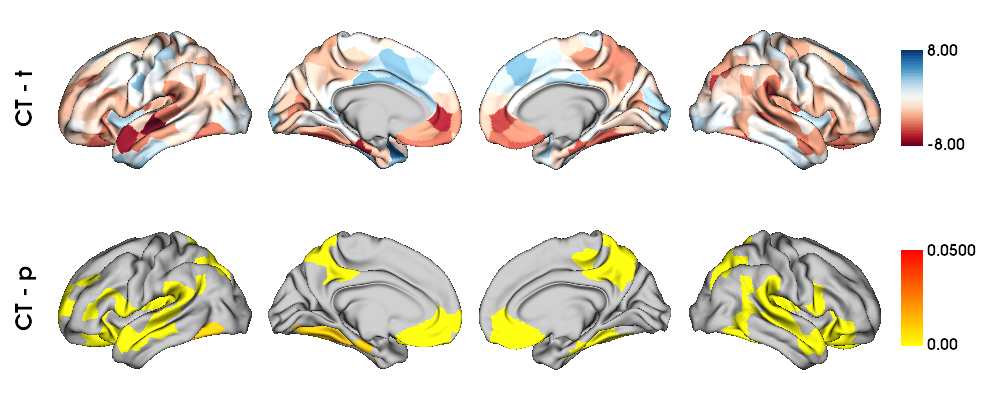

In [82]:
slm_gab_sa = SLM(model, contrast_gab, surf = surf, correction = ['fdr', 'rft'], cluster_threshold = 0.01)
slm_gab_sa.fit(SA_model)

# derive t and p values
t_gab_sa = slm_gab_sa.t[0]*-1
t_gab_sa[mask] = np.nan

p_gab_sa = slm_gab_sa.P["pval"]["C"]
p_gab_sa[p_gab_sa>0.05] = np.nan

array_to_plot = [t_gab_sa, p_gab_sa]

plot_hemispheres(surf_lh, surf_rh, array_to_plot, size=(1000, 400), label_text=['CT - t', 'CT - p'], cmap=['RdBu', 'autumn_r'], color_range = [(-8,8), (0,0.05)], nan_color = (0.7,0.7,0.7,1),
                 color_bar=True, zoom=1.25, embed_nb = True)

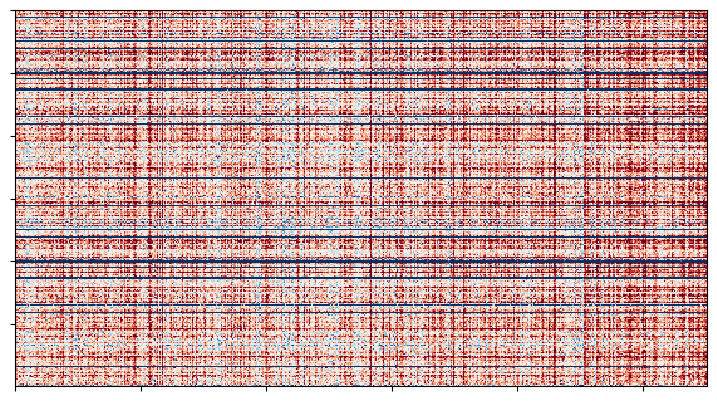

In [50]:
plotting.plot_matrix(CT_sorted.T, vmin= 0.8, vmax =1.3, colorbar=False)

## Covariance Gradients